In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

from sklearn.utils import shuffle

import argparse
import os

from matplotlib.backends.backend_pdf import PdfPages
import pickle

from helpers.data_transforms import clean_data, bootstrap_array
from helpers.BDT import *
from helpers.physics_functions import *
from helpers.plotting import hist_all_features_array
from helpers.evaluation import assemble_banded_datasets, convert_to_latent_space_true_cathode, get_median_percentiles
from helpers.make_BC import *

In [2]:

import yaml
with open(f"workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)


train_samesign = False
if train_samesign: samesign_id = "SS"
else: samesign_id = "OS"

# TODO: implement for inner bands
bands = ["SBL", "SR", "SBH"]
data_dict = {}

if train_samesign:
    train_data_id = "SS"
    alt_test_data_id = "OS"
else:
    train_data_id = "OS"
    alt_test_data_id = "SS"

In [3]:
bootstrap_flow = "bootstrap0"
configs = "CATHODE_8"
feature_id = "mix_2"

working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/{bootstrap_flow}_{samesign_id}/{feature_id}/{configs}/"


In [4]:
seeds = "1,2,3,4,5"
bkg_fit_type = "quintic"
num_bins_SR = 12
    
# load in the flow samples corresponding to the train id
seeds_list = [int(x) for x in seeds.split(",")]
train_samples_dict = {'SR_samples_ROC':[], 'SBL_samples_ROC':[], 'SBH_samples_ROC':[], 'SR_samples_validation':[], 'SR_samples':[]}
for seed in seeds_list:
    path_to_samples = f"{flow_training_dir}/seed{seed}/flow_samples_{bkg_fit_type}_{num_bins_SR}"
    with open(path_to_samples, "rb") as infile: 
        loc_train_samples_dict = pickle.load(infile)
        for key in train_samples_dict.keys():
            train_samples_dict[key].append(loc_train_samples_dict[key])
for key in train_samples_dict.keys():
    train_samples_dict[key] = np.vstack(train_samples_dict[key])
    print(key, train_samples_dict[key].shape)
           

SR_samples_ROC (7930, 4)
SBL_samples_ROC (34620, 4)
SBH_samples_ROC (18580, 4)
SR_samples_validation (7930, 4)
SR_samples (7930, 4)


In [5]:
run_null = False
bootstrap_data = "bootstrap0"

if not run_null:
    # load in the data corresponding to the train id
    # we actually want the "test band" here -- train is just for flow
    with open(f"{processed_data_dir}/{bootstrap_data}_{train_data_id}_test_band_data", "rb") as ifile:
        test_data_dict = pickle.load(ifile)
    # load in the alternative data
    with open(f"{processed_data_dir}/{bootstrap_data}_{alt_test_data_id}_test_band_data", "rb") as ifile:
        alt_test_data_dict = pickle.load(ifile)
 
    print(f"Loading classifier train samples from {processed_data_dir}/bootstrap{bootstrap_data}_{train_data_id}_test_band_data")
    print(f"Loading classifier train data from {processed_data_dir}/bootstrap{bootstrap_data}_{train_data_id}_test_band_data")
    print(f"Loading alternative test data from {processed_data_dir}/bootstrap{bootstrap_data}_{alt_test_data_id}_test_band_dat")
    print()

elif run_null:
    with open(f"{processed_data_dir}/bkg_samples/{bootstrap_data}_{train_data_id}_test_band_data", "rb") as ifile:
        test_data_dict = pickle.load(ifile)
    # load in the alternative data
    with open(f"{processed_data_dir}/bkg_samples/{bootstrap_data}_{alt_test_data_id}_test_band_data", "rb") as ifile:
        alt_test_data_dict = pickle.load(ifile)

    print(f"Loading classifier train samples from {processed_data_dir}/bkg_samples/bootstrap{bootstrap_data}_{train_data_id}_test_band_data")
    print(f"Loading classifier train data from {processed_data_dir}/bkg_samples/bootstrap{bootstrap_data}_{train_data_id}_test_band_data")
    print(f"Loading alternative test data from {processed_data_dir}/bkg_samples/bootstrap{bootstrap_data}_{alt_test_data_id}_test_band_dat")
    print()
    


Loading classifier train samples from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/processed_data/bootstrapbootstrap0_OS_test_band_data
Loading classifier train data from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/processed_data/bootstrapbootstrap0_OS_test_band_data
Loading alternative test data from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/processed_data/bootstrapbootstrap0_SS_test_band_dat



In [6]:
with open(f"{flow_training_dir}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(feature_set)

n_features = len(feature_set) - 1


# Assemble the test sets -- consists of both SB and SR
        
# test set events: not used during flow training
banded_test_data = assemble_banded_datasets(test_data_dict, feature_set, bands)

# alt test set events
banded_alt_test_data = assemble_banded_datasets(alt_test_data_dict, feature_set, bands)





num_test_events = banded_test_data["SR"].shape[0]+banded_test_data["SBL"].shape[0]+banded_test_data["SBH"].shape[0]
print(f"Total number of default test events: {num_test_events}.")
num_test_events = banded_alt_test_data["SR"].shape[0]+banded_alt_test_data["SBL"].shape[0]+banded_alt_test_data["SBH"].shape[0]
print(f"Total number of alt test events: {num_test_events}.")


    
SR_min_rescaled = np.min(banded_test_data["SR"][:,-1])
SR_max_rescaled = np.max(banded_test_data["SR"][:,-1])

    

['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']
Total number of default test events: 12332.
Total number of alt test events: 7168.


In [7]:
num_to_ensemble = 100


bdt_hyperparams_dict = {
    "n_estimators": 300, # number of boosting stages
    "max_depth":3, # max depth of individual regression estimators; related to complexity
    "learning_rate":0.1,  # stop training BDT is validation loss doesn't improve after this many rounds
    "subsample":0.7,   # fraction of samples to be used for fitting the individual base learners
    "early_stopping_rounds":10,
    "n_ensemble": num_to_ensemble
    
}



nn_hyperparams_dict = {
    "n_epochs": 300, # number of boosting stages
    "batch_size":64, # max depth of individual regression estimators; related to complexity
    "lr":0.001,  # stop training BDT is validation loss doesn't improve after this many rounds
    "layers":[4],   # fraction of samples to be used for fitting the individual base learners
    "n_ensemble": num_to_ensemble

}



In [8]:

start, stop = 0, 1


all_test_data_splits = {pseudo_e:{} for pseudo_e in range(start, stop)}
all_scores_splits = {pseudo_e:{} for pseudo_e in range(start, stop)}
all_alt_data_splits = {pseudo_e:{} for pseudo_e in range(start, stop)}
all_alt_scores_splits = {pseudo_e:{} for pseudo_e in range(start, stop)}




In [9]:
from sklearn.preprocessing import StandardScaler


In [10]:
def train_BDT(X_train, Y_train, w_train, X_val, Y_val, w_val, X_test, scores_fold, alt_data_splits, alt_scores_fold, random_seed, i_tree, i_fold, hyperparameters_dict, device="cpu"):

    
    eval_set = [(X_train, Y_train), (X_val, Y_val)]

    bst_i = xgb.XGBClassifier(n_estimators= hyperparameters_dict["n_estimators"], max_depth= hyperparameters_dict["max_depth"], learning_rate= hyperparameters_dict["learning_rate"], 
                      subsample= hyperparameters_dict["subsample"],  early_stopping_rounds= hyperparameters_dict["early_stopping_rounds"],
                      objective='binary:logistic', 
                              random_state = random_seed, eval_metric="logloss")

    bst_i.fit(X_train, Y_train, sample_weight=w_train, 
              eval_set=eval_set, sample_weight_eval_set = [w_train, w_val],
              verbose=False)
    results_f = bst_i.evals_result()
    losses = results_f["validation_0"]["logloss"]
    losses_val = results_f["validation_1"]["logloss"]
    best_epoch = bst_i.best_iteration

    # get scores
    scores_fold[:,i_tree] = bst_i.predict_proba(X_test, iteration_range=(0,bst_i.best_iteration))[:,1]
    for alt_id in alt_scores_fold.keys():
        alt_scores_fold[alt_id][:,i_tree] = bst_i.predict_proba(alt_data_splits[alt_id][i_fold][:,:-1], iteration_range=(0,bst_i.best_iteration))[:,1]

    return scores_fold, alt_data_splits, alt_scores_fold, losses, losses_val, best_epoch


def train_NN(X_train, Y_train, w_train, X_val, Y_val, w_val, X_test, scores_fold, alt_data_splits, alt_scores_fold, random_seed, i_tree, i_fold, hyperparameters_dict, device="cpu"):
    
    n_epochs = hyperparameters_dict["n_epochs"]
    batch_size = hyperparameters_dict["batch_size"]
    lr = hyperparameters_dict["lr"]
    layers = hyperparameters_dict["layers"]

    model_path = f"a.pt"
    
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    
    loc_scaler = StandardScaler().fit(X_train)
    X_train = loc_scaler.transform(X_train)
    X_val = loc_scaler.transform(X_val)

    # send to device
    X_train = np_to_torch(X_train, device)
    Y_train = np_to_torch(Y_train, device)
    w_train = np_to_torch(w_train, device)
    
    X_val = np_to_torch(X_val, device)
    Y_val = np_to_torch(Y_val, device)
    w_val = np_to_torch(w_val, device)
    
    train_set = torch.utils.data.TensorDataset(X_train, Y_train, w_train)
    val_set = torch.utils.data.TensorDataset(X_val, Y_val, w_val)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

    # initialze the network
    dense_net = NeuralNet(layers = layers, n_inputs = X_train.shape[1])
    criterion = F.binary_cross_entropy 
    optimizer = torch.optim.Adam(dense_net.parameters(), lr=lr)
    dense_net.to(device)

    early_stopping = EarlyStopping()

     # save the best model
    val_loss_to_beat = 1e10
    best_epoch = -1

    epochs, losses, losses_val = [], [], []

    for epoch in tqdm(range(n_epochs)):
        losses_batch_per_e = []
        # batching    
        for batch_index, (batch_data, batch_labels, batch_weights) in enumerate(train_loader):

            # calculate the loss, backpropagate
            optimizer.zero_grad()
            loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses_batch_per_e.append(loss.detach().cpu().numpy())

        epochs.append(epoch)
        losses.append(np.mean(losses_batch_per_e))

        # validation
        with torch.no_grad():
            val_losses_batch_per_e = []

            for batch_index, (batch_data, batch_labels, batch_weights) in enumerate(val_loader):
                # calculate the loss, backpropagate
                optimizer.zero_grad()
                val_loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights) 
                val_losses_batch_per_e.append(val_loss.detach().cpu().numpy())

            losses_val.append(np.mean(val_losses_batch_per_e))

            # see if the model has the best val loss
            if np.mean(val_losses_batch_per_e) < val_loss_to_beat:
                val_loss_to_beat = np.mean(val_losses_batch_per_e)
                # save the model
                torch.save(dense_net, model_path)
                best_epoch = epoch

            early_stopping(np.mean(val_losses_batch_per_e))

        if early_stopping.early_stop:
            break

    model_eval = torch.load(model_path)
    with torch.no_grad():
        model_eval.eval()

        # get scores
        scores_fold[:,i_tree] = model_eval(np_to_torch(X_test, device)).reshape(-1,)
                    
        for alt_id in alt_scores_fold.keys():
            alt_scores_fold[alt_id][:,i_tree] = model_eval(np_to_torch(alt_data_splits[alt_id][i_fold][:,:-1],device)).reshape(-1,)

    return scores_fold, alt_data_splits, alt_scores_fold, losses, losses_val, best_epoch



In [11]:
def run_BDT_bump_hunt(flow_samples_SR, data_samples_SR, data_samples_SB, num_folds, hyperparams_dict, 
                      alt_test_sets_data={}, visualize=True, pdf=None, take_ensemble_avg=False, run_BDT = True):
    
    """
    Classifier is trained only on SR data, to distinguish flow SR samples from SR data
    
    Classifier is evaluated on test data from SR AND SB
    
    Note that alt test sets are NOT split into folds, since we aren't training on them. We do get diff scores for each fold
    """
    
    test_data_splits  = {i:0 for i in range(num_folds)}
    scores_splits = {i:0 for i in range(num_folds)}
    
    # split the alternative test sets
    alt_scores_splits = {}
    alt_data_splits = {}
    for alt_id in alt_test_sets_data.keys():
        alt_scores_splits[alt_id] = {i:0 for i in range(num_folds)}
        # generate a nfold split for the alt test data
        loc_alt_data_split = np.array_split(shuffle(alt_test_sets_data[alt_id]), num_folds) 
        alt_data_splits[alt_id] = {i:loc_alt_data_split[i] for i in range(num_folds)}
        
    # shuffle anything with SB data to mix the low and high masses before splitting 
    #flow_samples_SR = shuffle(flow_samples_SR)
    #data_samples_SR = shuffle(data_samples_SR)
    #data_samples_SB = shuffle(data_samples_SB)
    
    flow_SR_splits = np.array_split(flow_samples_SR, num_folds)
    data_SR_splits = np.array_split(data_samples_SR, num_folds)
    data_SB_splits = np.array_split(data_samples_SB, num_folds) 
    
    for i_fold in range(num_folds):
            
        print(f"Fold {i_fold}:")
        
        """
        ASSEMBLE THE TRAIN / VAL / TEST DATA
        """
        
        # Assemble the train / test data
        training_data, training_labels = [], []
        validation_data, validation_labels = [], []
        testing_data = []

        for ii in range(num_folds):
            
            # test set comprised of SR and SB data
            if ii == i_fold:
                testing_data.append(data_SR_splits[ii])
                testing_data.append(data_SB_splits[ii])
                
            # validation set: flow SR samples, data SR sampkes
            elif ((ii+1)%num_folds) == i_fold:
                validation_data.append(flow_SR_splits[ii])
                validation_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                validation_data.append(data_SR_splits[ii])
                validation_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
            else:
                training_data.append(flow_SR_splits[ii])
                training_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                training_data.append(data_SR_splits[ii])
                training_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
        X_train_fold = np.concatenate(training_data)
        Y_train_fold = np.concatenate(training_labels)
        X_val_fold = np.concatenate(validation_data)
        Y_val_fold = np.concatenate(validation_labels)
        
        X_test_fold = np.concatenate(testing_data)
        
        # record the local fold data
        test_data_splits[i_fold] = X_test_fold
     
        """
        SORT THE WEIGHTS OUT
        """
        
        # First do the weights for the regular BC (non-decorr)
        class_weight = {0: 1, 1: sum(Y_train_fold==0)[0]/sum(Y_train_fold==1)[0]}
        class_weights_train = class_weight[0]*(1.0-Y_train_fold)+class_weight[1]*Y_train_fold
        class_weights_val = class_weight[0]*(1.0-Y_val_fold)+class_weight[1]*Y_val_fold
        
        """
        COMBINE W/ DECORRELATED TRAINING
        """
        # we only want to train on the non-mass features

        X_train_fold = X_train_fold[:,:-1]
        X_val_fold = X_val_fold[:,:-1]

        w_train_fold = class_weights_train
        w_val_fold = class_weights_val

        # shuffle for good measure
        X_train_fold, Y_train_fold, w_train_fold = shuffle(X_train_fold, Y_train_fold, w_train_fold)
        X_val_fold, Y_val_fold, w_val_fold = shuffle(X_val_fold, Y_val_fold, w_val_fold)
        
        X_test_fold = X_test_fold[:,:-1]
        
        
        print(f"X train shape: {X_train_fold.shape}, Y train shape: {Y_train_fold.shape}, w train shape: {w_train_fold.shape}.")
        print(f"X val shape: {X_val_fold.shape}, Y val shape: {Y_val_fold.shape}, w val shape: {w_val_fold.shape}.")
        print(f"X test shape: {X_test_fold.shape}." )
        
        """
        INITIALIZE SCORE OBJECTS
        """
        
        scores_fold = np.empty((X_test_fold.shape[0], hyperparams_dict["n_ensemble"]))
        alt_scores_fold = {}
        for alt_id in alt_test_sets_data.keys():
            alt_scores_fold[alt_id] = np.empty((alt_data_splits[alt_id][i_fold].shape[0],  hyperparams_dict["n_ensemble"]))
            
   
        """
        TRAIN ENSEMBLE OF TREES
        """
    

        plt.figure()

        for i_tree in range( hyperparams_dict["n_ensemble"]):
            
            if i_tree % 10 == 0:
                print("   Network number:", i_tree)
            random_seed = i_fold* hyperparams_dict["n_ensemble"] + i_tree + 1

            if run_BDT:
        
                scores_fold, alt_data_splits, alt_scores_fold, losses, losses_val, best_epoch = train_BDT(X_train_fold, Y_train_fold, w_train_fold, X_val_fold, Y_val_fold, w_val_fold, X_test_fold, scores_fold, alt_data_splits, alt_scores_fold, random_seed, i_tree, i_fold, hyperparams_dict, device="cpu")

            else:
                scores_fold, alt_data_splits, alt_scores_fold, losses, losses_val, best_epoch = train_NN(X_train_fold, Y_train_fold, w_train_fold, X_val_fold, Y_val_fold, w_val_fold, X_test_fold, scores_fold, alt_data_splits, alt_scores_fold, random_seed, i_tree, i_fold, hyperparams_dict, device="cpu")

            
                
            plt.plot(losses, label = f"{i_tree}", color = f"C{i_tree}")
            plt.plot(losses_val, color = f"C{i_tree}", linestyle = "dashed")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.axvline(best_epoch, color = f"C{i_tree}")
            plt.title(f"Fold {i_fold}")
        plt.show()
        
       
            
        """
        AVERAGE OVER ENSEMBLE
        """     
        if take_ensemble_avg:
            scores_splits[i_fold] = np.mean(scores_fold, axis = 1)
            for alt_id in alt_test_sets_data.keys():
                alt_scores_splits[alt_id][i_fold] = np.mean(alt_scores_fold[alt_id], axis = 1)
        else:
            scores_splits[i_fold] = scores_fold
            for alt_id in alt_test_sets_data.keys():
                alt_scores_splits[alt_id][i_fold] = alt_scores_fold[alt_id]

    
    plt.figure()
    for i in range(5):
        plt.hist(scores_splits[i],density = True, histtype = "step", label = i, bins = np.linspace(0, 1, 100))
    plt.legend()
    plt.title(f"run bdt {run_BDT}")
    plt.show()
        
     
    return test_data_splits, scores_splits, alt_data_splits, alt_scores_splits




  0%|          | 1/300 [00:00<00:43,  6.88it/s]

On pseudoexperiment 0 (of 0 to 1)...
Not bootstrapping data
Fold 0:
X train shape: (5773, 3), Y train shape: (5773, 1), w train shape: (5773, 1).
X val shape: (1924, 3), Y val shape: (1924, 1), w val shape: (1924, 1).
X test shape: (2467, 3).
   Network number: 0


  1%|          | 2/300 [00:00<00:28, 10.40it/s]

   Network number: 10


  1%|          | 2/300 [00:00<00:28, 10.40it/s]

   Network number: 20


  1%|          | 2/300 [00:00<00:28, 10.40it/s]

   Network number: 30


  1%|          | 2/300 [00:00<00:28, 10.45it/s]

   Network number: 40


  1%|          | 2/300 [00:00<00:28, 10.37it/s]

   Network number: 50


  1%|          | 2/300 [00:00<00:28, 10.34it/s]

   Network number: 60


  1%|          | 2/300 [00:00<00:28, 10.37it/s]

   Network number: 70


  1%|          | 2/300 [00:00<00:28, 10.35it/s]

   Network number: 80


  1%|          | 2/300 [00:00<00:29, 10.27it/s]

   Network number: 90


  6%|▌         | 17/300 [00:01<00:28,  9.78it/s]


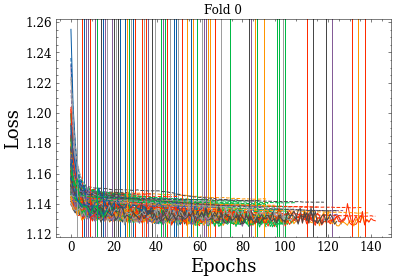

  0%|          | 0/300 [00:00<?, ?it/s]

Fold 1:
X train shape: (5772, 3), Y train shape: (5772, 1), w train shape: (5772, 1).
X val shape: (1925, 3), Y val shape: (1925, 1), w val shape: (1925, 1).
X test shape: (2467, 3).
   Network number: 0


  1%|          | 2/300 [00:00<00:28, 10.44it/s]

   Network number: 10


  1%|          | 2/300 [00:00<00:28, 10.36it/s]

   Network number: 20


  1%|          | 2/300 [00:00<00:28, 10.35it/s]

   Network number: 30


  1%|          | 2/300 [00:00<00:28, 10.38it/s]

   Network number: 40


  1%|          | 2/300 [00:00<00:28, 10.41it/s]

   Network number: 50


  1%|          | 2/300 [00:00<00:28, 10.29it/s]

   Network number: 60


  1%|          | 2/300 [00:00<00:29, 10.24it/s]

   Network number: 70


  1%|          | 2/300 [00:00<00:29, 10.26it/s]

   Network number: 80


  1%|          | 2/300 [00:00<00:28, 10.34it/s]

   Network number: 90


  8%|▊         | 25/300 [00:02<00:27,  9.97it/s]


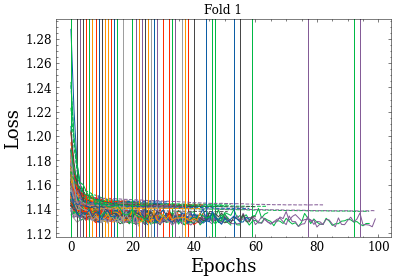

  0%|          | 0/300 [00:00<?, ?it/s]

Fold 2:
X train shape: (5773, 3), Y train shape: (5773, 1), w train shape: (5773, 1).
X val shape: (1925, 3), Y val shape: (1925, 1), w val shape: (1925, 1).
X test shape: (2466, 3).
   Network number: 0


  0%|          | 0/300 [00:00<?, ?it/s]

   Network number: 10


  1%|          | 2/300 [00:00<00:28, 10.45it/s]

   Network number: 20


  1%|          | 2/300 [00:00<00:28, 10.35it/s]

   Network number: 30


  1%|          | 2/300 [00:00<00:28, 10.45it/s]

   Network number: 40


  1%|          | 2/300 [00:00<00:28, 10.44it/s]

   Network number: 50


  1%|          | 2/300 [00:00<00:28, 10.46it/s]

   Network number: 60


  0%|          | 0/300 [00:00<?, ?it/s]

   Network number: 70


  0%|          | 0/300 [00:00<?, ?it/s]

   Network number: 80


  1%|          | 2/300 [00:00<00:28, 10.35it/s]

   Network number: 90


  3%|▎         | 10/300 [00:01<00:30,  9.48it/s]


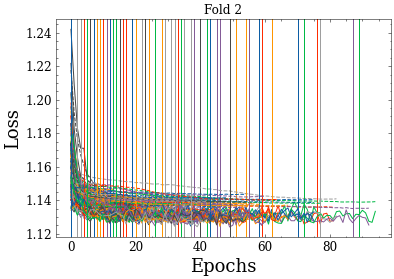

  0%|          | 0/300 [00:00<?, ?it/s]

Fold 3:
X train shape: (5774, 3), Y train shape: (5774, 1), w train shape: (5774, 1).
X val shape: (1924, 3), Y val shape: (1924, 1), w val shape: (1924, 1).
X test shape: (2466, 3).
   Network number: 0


  1%|          | 2/300 [00:00<00:28, 10.35it/s]

   Network number: 10


  1%|          | 2/300 [00:00<00:28, 10.29it/s]

   Network number: 20


  1%|          | 2/300 [00:00<00:28, 10.38it/s]

   Network number: 30


  1%|          | 2/300 [00:00<00:28, 10.33it/s]

   Network number: 40


  1%|          | 2/300 [00:00<00:28, 10.46it/s]

   Network number: 50


  1%|          | 2/300 [00:00<00:28, 10.43it/s]

   Network number: 60


  1%|          | 2/300 [00:00<00:28, 10.43it/s]

   Network number: 70


  1%|          | 2/300 [00:00<00:28, 10.34it/s]

   Network number: 80


  1%|          | 2/300 [00:00<00:28, 10.44it/s]

   Network number: 90


  8%|▊         | 25/300 [00:02<00:27,  9.95it/s]


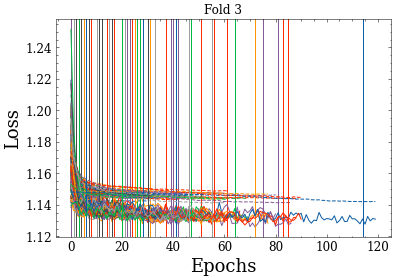

  0%|          | 1/300 [00:00<00:30,  9.91it/s]

Fold 4:
X train shape: (5774, 3), Y train shape: (5774, 1), w train shape: (5774, 1).
X val shape: (1924, 3), Y val shape: (1924, 1), w val shape: (1924, 1).
X test shape: (2466, 3).
   Network number: 0


  1%|          | 2/300 [00:00<00:29, 10.21it/s]

   Network number: 10


  1%|          | 2/300 [00:00<00:29, 10.26it/s]

   Network number: 20


  1%|          | 2/300 [00:00<00:28, 10.34it/s]

   Network number: 30


  0%|          | 1/300 [00:00<00:30,  9.66it/s]

   Network number: 40


  1%|          | 2/300 [00:00<00:28, 10.35it/s]

   Network number: 50


  1%|          | 2/300 [00:00<00:28, 10.28it/s]

   Network number: 60


  0%|          | 1/300 [00:00<00:34,  8.67it/s]

   Network number: 70


  0%|          | 0/300 [00:00<?, ?it/s]

   Network number: 80


  1%|          | 2/300 [00:00<00:29, 10.26it/s]

   Network number: 90


  4%|▍         | 13/300 [00:01<00:29,  9.63it/s]


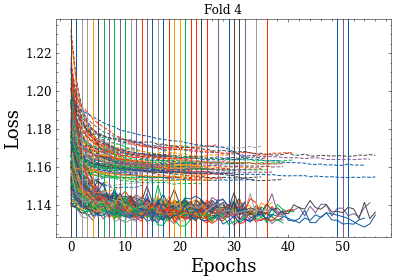

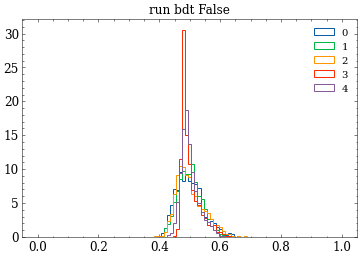

Fold 0:
X train shape: (5773, 3), Y train shape: (5773, 1), w train shape: (5773, 1).
X val shape: (1924, 3), Y val shape: (1924, 1), w val shape: (1924, 1).
X test shape: (2467, 3).
   Network number: 0
   Network number: 10
   Network number: 20
   Network number: 30
   Network number: 40
   Network number: 50
   Network number: 60
   Network number: 70
   Network number: 80
   Network number: 90


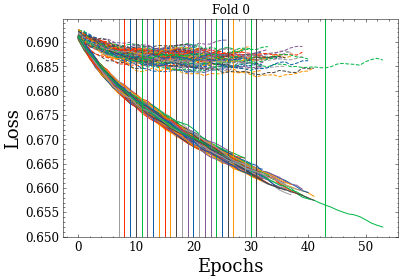

Fold 1:
X train shape: (5772, 3), Y train shape: (5772, 1), w train shape: (5772, 1).
X val shape: (1925, 3), Y val shape: (1925, 1), w val shape: (1925, 1).
X test shape: (2467, 3).
   Network number: 0
   Network number: 10
   Network number: 20
   Network number: 30
   Network number: 40
   Network number: 50
   Network number: 60
   Network number: 70
   Network number: 80
   Network number: 90


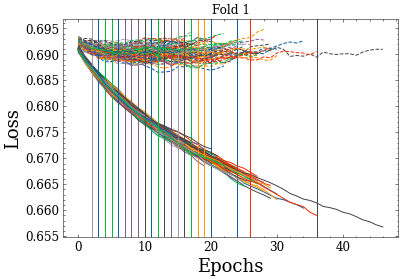

Fold 2:
X train shape: (5773, 3), Y train shape: (5773, 1), w train shape: (5773, 1).
X val shape: (1925, 3), Y val shape: (1925, 1), w val shape: (1925, 1).
X test shape: (2466, 3).
   Network number: 0
   Network number: 10
   Network number: 20
   Network number: 30
   Network number: 40
   Network number: 50
   Network number: 60
   Network number: 70
   Network number: 80
   Network number: 90


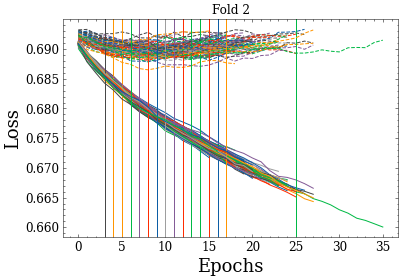

Fold 3:
X train shape: (5774, 3), Y train shape: (5774, 1), w train shape: (5774, 1).
X val shape: (1924, 3), Y val shape: (1924, 1), w val shape: (1924, 1).
X test shape: (2466, 3).
   Network number: 0
   Network number: 10
   Network number: 20
   Network number: 30
   Network number: 40
   Network number: 50
   Network number: 60
   Network number: 70
   Network number: 80
   Network number: 90


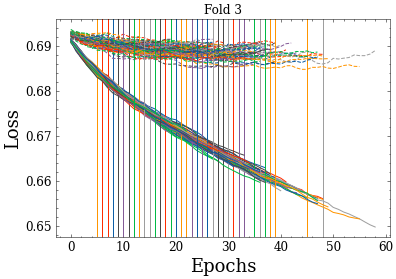

Fold 4:
X train shape: (5774, 3), Y train shape: (5774, 1), w train shape: (5774, 1).
X val shape: (1924, 3), Y val shape: (1924, 1), w val shape: (1924, 1).
X test shape: (2466, 3).
   Network number: 0
   Network number: 10
   Network number: 20
   Network number: 30
   Network number: 40
   Network number: 50
   Network number: 60
   Network number: 70
   Network number: 80
   Network number: 90


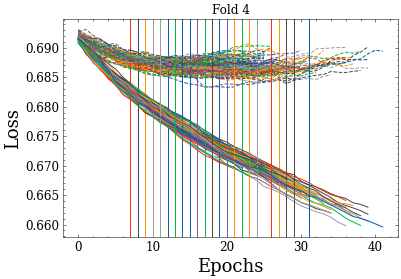

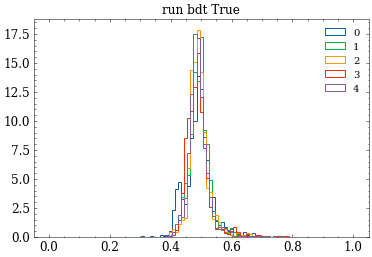

**********

Done training BDTs!


In [12]:
for pseudo_e in range(start, stop):
    
    print(f"On pseudoexperiment {pseudo_e} (of {start} to {stop})...")
    
    if pseudo_e == 0:
        
        print("Not bootstrapping data")
        loc_alt_test_set = np.vstack([banded_alt_test_data["SR"],banded_alt_test_data["SBL"],banded_alt_test_data["SBH"]])
      
        loc_ROC_test_samples_2 = np.vstack([train_samples_dict["SR_samples_ROC"],train_samples_dict["SBL_samples_ROC"],train_samples_dict["SBH_samples_ROC"]])
        loc_SB_test_set = np.vstack([clean_data(banded_test_data["SBL"]),clean_data(banded_test_data["SBH"])])
        loc_SR_data = clean_data(banded_test_data["SR"])
        loc_FPR_val_set = train_samples_dict["SR_samples_validation"]
        
        loc_SR_samples = clean_data(train_samples_dict["SR_samples"])

    
            
        loc_alt_test_sets_data = {"FPR_validation":loc_FPR_val_set,
                          "alt":loc_alt_test_set,
                         "ROC_samples":loc_ROC_test_samples_2}
        
        test_data_splits_nn, scores_splits_nn, alt_data_splits_nn, alt_scores_splits_nn = run_BDT_bump_hunt(loc_SR_samples, loc_SR_data, 
                                                                                loc_SB_test_set, 5, nn_hyperparams_dict, 
                                                            alt_test_sets_data=loc_alt_test_sets_data, visualize=True, pdf=None, 
                                                                                        take_ensemble_avg=True, run_BDT = False)

        test_data_splits_bdt, scores_splits_bdt, alt_data_splits_bdt, alt_scores_splits_bdt = run_BDT_bump_hunt(loc_SR_samples, loc_SR_data, 
                                                                                loc_SB_test_set, 5, bdt_hyperparams_dict, 
                                                            alt_test_sets_data=loc_alt_test_sets_data, visualize=True, pdf=None, 
                                                                                        take_ensemble_avg=True, run_BDT = True)
    
       

    else:
      pass
    
    
    print(10*"*"+"\n")

print("Done training BDTs!")


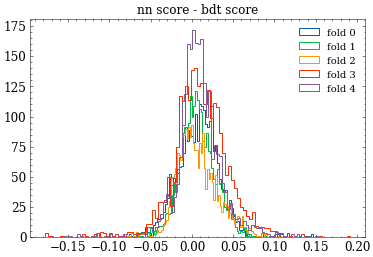

In [15]:
plt.figure()
for i in range(5):
    plt.hist(scores_splits_nn[i]-scores_splits_bdt[i], bins = 100, histtype= "step", label = f"fold {i}")
plt.title("nn score - bdt score")
plt.legend()
plt.show()

In [14]:
print(test_data_splits_nn)
print(test_data_splits_bdt)

{0: array([[-0.81221342, -0.66701466, -1.18074846,  0.1605211 ],
       [-0.51879823,  0.59437507,  0.8029604 ,  0.04854688],
       [ 0.68566489, -1.34916878, -0.53963584,  0.08022041],
       ...,
       [ 0.32638925,  0.90802884,  1.4042002 , -1.1832875 ],
       [ 0.16505961, -1.12396491, -0.52812499, -0.90706265],
       [-0.38489664,  1.75989234,  0.84671831, -1.09830046]]), 1: array([[ 0.36399287,  1.14060616, -0.74398863,  0.39129141],
       [ 2.01483965, -1.09337306, -0.97398633,  0.13757268],
       [ 0.82426208, -1.56919479, -0.83161378,  0.35831594],
       ...,
       [ 0.38831726, -0.39998701, -0.67729449, -0.71663463],
       [-0.68788201, -1.3065753 ,  1.80804646, -0.26246652],
       [ 0.39933893, -1.31391561,  0.31545016, -1.18989098]]), 2: array([[-0.01606669, -1.21333802,  0.66027057,  0.2034484 ],
       [ 0.55314296,  1.58742476, -1.28933477,  0.32239941],
       [ 1.6603266 , -1.1531198 , -1.2674495 ,  0.00983986],
       ...,
       [ 2.91334295, -0.1328699 ,  